In [1]:
from make_trace import make_traces, MAX_TTL
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import csv
import ipaddress
from bisect import bisect_left
import math

In [34]:
#cache
reachability_data = {}

In [3]:
traces_fly = make_traces('./data/fly.csv')
traces_gcp = make_traces('./data/gcp.csv')
traces_local = make_traces('./data/local.csv')

In [4]:
ip_fly = "216.246.119.87"
ip_gcp = "34.30.42.157"
ip_local = "130.89.162.90"

In [5]:
TIER1_ASNS = [7018, 3320, 3257, 6830, 3356, 2914, 5511, 3491, 1239, 6453, 6762, 1299, 12956, 701, 6461]
TIER2_ASNS = [
    6939, 7713, 9002, 1764, 34549, 4766, 9304, 22652, 9318, 3292, 2497, 1273, 2516, 23947, 4134,
    4809, 4837, 3462, 5400, 7922, 1257, 12390, 2711, 8002, 14744, 38930, 33891, 41327, 7473, 24482,
    9121, 6663
]

In [6]:
tier1_ranges = []
tier2_ranges = []
with open("./asn.csv", newline='', encoding='utf-8-sig') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip header
    for start_ip, end_ip, asn, name, domain in reader:
        start = ipaddress.ip_address(start_ip)
        if start.version == 4:
            if int(asn.lstrip('AS')) in TIER1_ASNS:
                tier1_ranges.append((start, ipaddress.ip_address(end_ip)))
            elif int(asn.lstrip('AS')) in TIER2_ASNS:
                tier2_ranges.append((start, ipaddress.ip_address(end_ip)))
tier1_ranges.sort()
tier1_starts = [entry[0] for entry in tier1_ranges]
tier2_ranges.sort()
tier2_starts = [entry[0] for entry in tier2_ranges]

In [51]:
def goes_trough_ip(trace, ips):
    return any(hop[0] in ips for hop in trace if hop is not None)

def ip_in_ip_ranges(ip, ranges, start_ips):
    ip_obj = ipaddress.ip_address(ip)
    idx = bisect_left(start_ips, ip_obj)
    
    candidates = []
    if idx < len(ranges):
        candidates.append(ranges[idx])
    if idx > 0:
        candidates.append(ranges[idx - 1])

    for start_ip, end_ip in candidates:
        if start_ip <= ip_obj <= end_ip:
            return True
    return False

def hop_distribution(traces):
    counter = Counter()
    for t in traces.values():
        l = len(list(filter(lambda hop: hop is not None,t)))
        if l > 0:
            counter[l] += 1
    return counter


def percentage_hop_distribution(traces):
    counter = Counter()
    for t in traces.values():
        l = len(list(filter(lambda hop: hop is not None,t)))
        if l > 0:
            counter[int(math.ceil(20*l/len(t)))*5] += 1
    return counter

def ignore_distribution(traces):
    counter = Counter()
    for t in [t for t in traces.values() if t[len(t)-1] is not None]:
        l = len(list(filter(lambda hop: hop is None,t)))
        if l > 0:
            counter[l] += 1
    return counter
    

def plot_reply_distributions():
    plt.figure(figsize=(10, 6))
    for traces, tag in [(traces_fly, "fly.io"), (traces_gcp, "google"), (traces_local, "local")]:
        # Extract x and y values
        x_values, y_values = zip(*sorted(hop_distribution(traces).items()))
        plt.plot(x_values, y_values, marker='o', label=tag)

    # Display the plot
    plt.grid(True)
    plt.title("Replies per trace")
    plt.xlabel('Hops with a reply')
    plt.ylabel('Traces')
    plt.legend()
    plt.savefig("reply_distribution.svg")
    plt.show()

def plot_percentage_reply_distributions():
    # Plotting the histograms
    plt.figure(figsize=(10, 6))
    for traces, tag in [(traces_fly, "fly.io"), (traces_gcp, "google"), (traces_local, "local")]:
        # Extract x and y values
        x_values, y_values = zip(*sorted(percentage_hop_distribution(traces).items()))
        plt.plot(x_values, y_values, label=tag)


    # Display the plot
    plt.grid(True)
    plt.title("Percentage of replies per trace (bin size = 5%)")
    plt.xlabel('Percentage of hops with a reply')
    plt.ylabel('Traces')
    plt.legend()
    plt.savefig("percentage_reply_distribution.svg")
    plt.show()

def plot_ignore_distributions():
    plt.figure(figsize=(10, 6))
    for traces, tag in [(traces_fly, "fly.io"), (traces_gcp, "google"), (traces_local, "local")]:
        # Extract x and y values
        x_values, y_values = zip(*sorted(ignore_distribution(traces).items()))
        plt.plot(x_values, y_values, marker='o', label=tag)

    # Display the plot
    plt.grid(True)
    plt.title("Hops without a reply for traces that reached the target")
    plt.xlabel('Hops without a reply')
    plt.ylabel('Traces')
    plt.legend()
    plt.savefig("ignore_distribution.svg")
    plt.show()


def calculate_reachability():
    #plt.figure(figsize=(10, 6))
    print()
    for traces, tag in [(traces_fly, "fly.io"), (traces_gcp, "google"), (traces_local, "local")]:
        reachability_data[tag] = []
        traces = list(traces.items())
        print(tag)
        total = len(traces)
        print("total:", total)
        reachability_data[tag].append(total)
        traces = list(filter(lambda trace: (len(trace[1]) == (MAX_TTL+1)) or (trace[1][len(trace[1])-1] is not None and trace[1][len(trace[1])-1][0] == trace[0]), traces))
        reachable = len(traces)
        print("reachable:", reachable)
        reachability_data[tag].append(reachable)
        traces = list(filter(lambda trace: not any(ip_in_ip_ranges(hop[0], tier1_ranges, tier1_starts) for hop in trace[1] if hop is not None), traces))
        reach_without_t1 = len(traces)
        print("reachable - T1:", reach_without_t1)
        reachability_data[tag].append(reach_without_t1)
        traces = list(filter(lambda trace: not any(ip_in_ip_ranges(hop[0], tier2_ranges, tier2_starts) for hop in trace[1] if hop is not None), traces))
        reach_without_t1_and_t2 = len(traces)
        print("reachable - T1 - T2:", reach_without_t1_and_t2)
        reachability_data[tag].append(reach_without_t1_and_t2)
        print()


def plot_reachability():
    if len(reachability_data) == 0:
        calculate_reachability()

    labels = []
    total = []
    reachable = []
    reachable_T1 = []
    reachable_T1_T2 = []
    for k, v in reachability_data.items():
        labels.append(k)
        total.append(v[0])
        reachable.append(v[1])
        reachable_T1.append(v[2])
        reachable_T1_T2.append(v[3])

    # Normalize the data and convert to percentages
    reachable_percentage = [r / t * 100 for r, t in zip(reachable, total)]
    reachable_T1_percentage = [r1 / t * 100 for r1, t in zip(reachable_T1, total)]
    reachable_T1_T2_percentage = [r2 / t * 100 for r2, t in zip(reachable_T1_T2, total)]

    # Setting the positions and width for the bars
    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    # Plotting the bars
    fig, ax = plt.subplots(figsize=(10, 6))  # Increase the width of the figure
    rects1 = ax.bar(x - width, reachable_percentage, width, label='Reachable')
    rects2 = ax.bar(x, reachable_T1_percentage, width, label='Reachable - T1')
    rects3 = ax.bar(x + width, reachable_T1_T2_percentage, width, label='Reachable - T1 - T2')

    # Adding some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('')
    ax.set_ylabel('IPv4 space reachability')
    ax.set_title('IPv4 reachability')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    # Place the legend outside of the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adding labels on top of the bars
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(3, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(rects1)
    add_labels(rects2)
    add_labels(rects3)

    fig.tight_layout()
    plt.savefig("reachability.svg")
    plt.show()


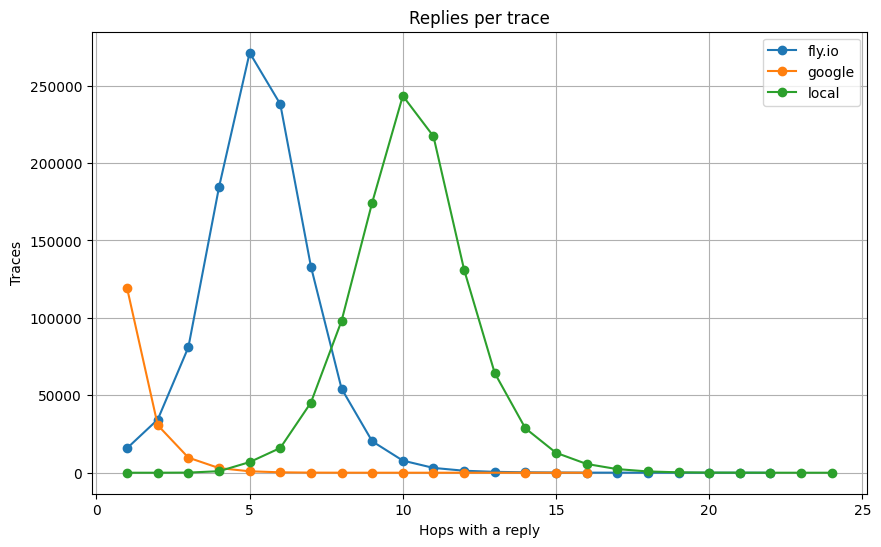

In [47]:
plot_reply_distributions()

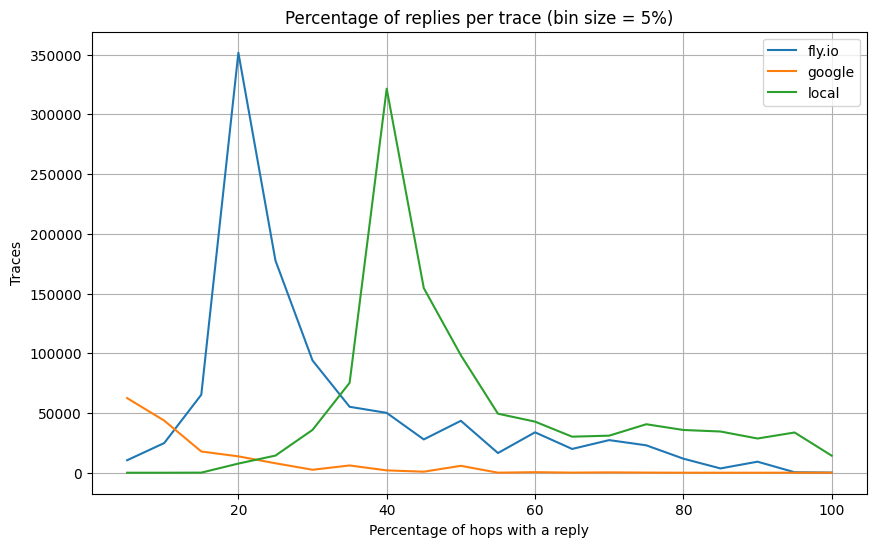

In [52]:
#plot_percentage_reply_distributions()
plot_percentage_reply_distributions()

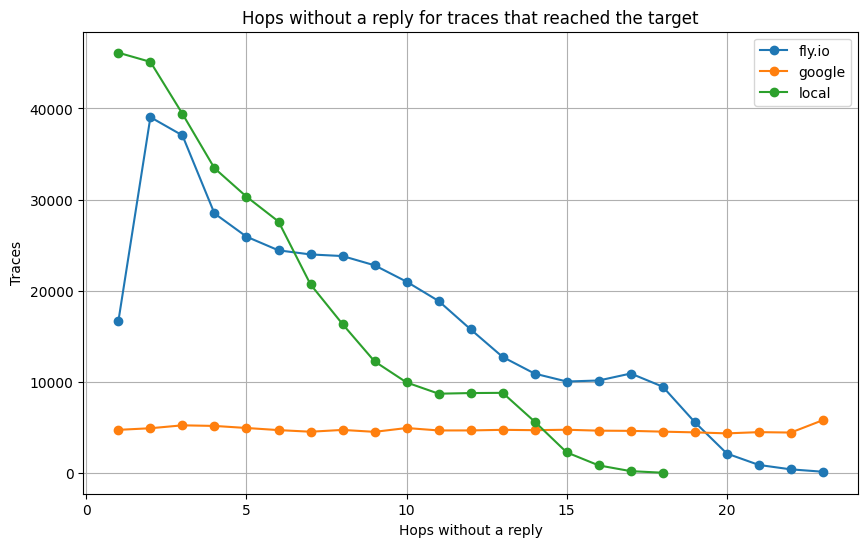

In [49]:
plot_ignore_distributions()

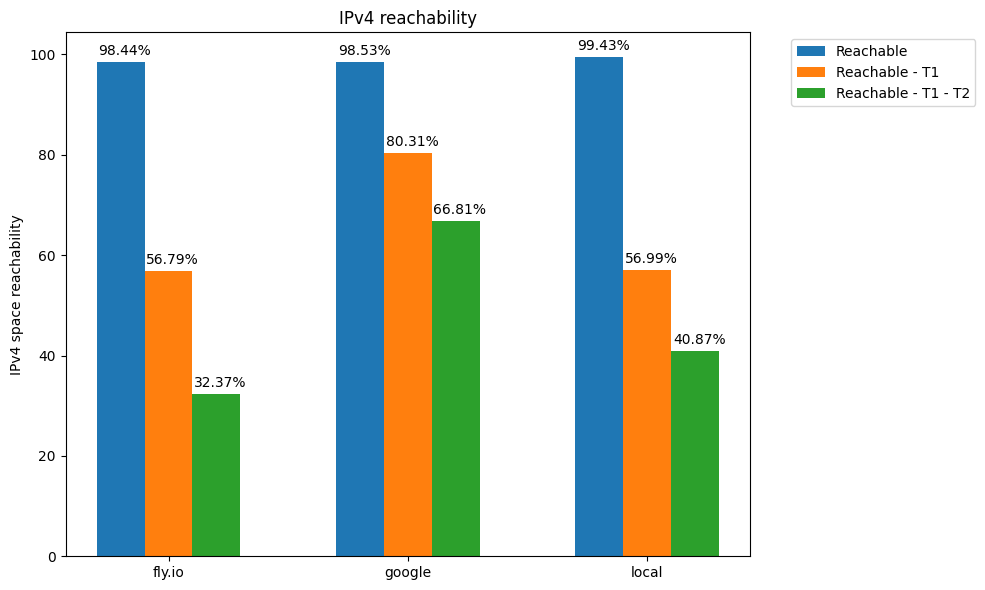

{'fly.io': [1046025, 1029725, 594061, 338623], 'google': [163781, 161381, 131538, 109430], 'local': [1048567, 1042625, 597586, 428519]}


In [50]:
plot_reachability()
print(reachability_data)

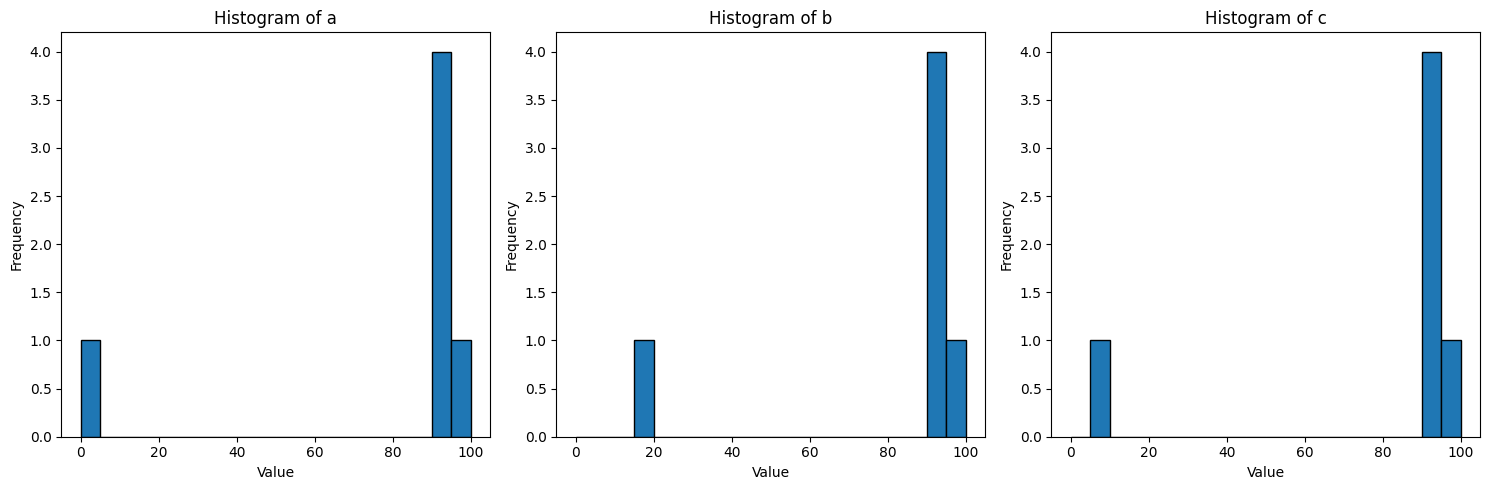

In [32]:
import matplotlib.pyplot as plt

# Given data
a = [(1.043478260869565, 2280), (92.85714285714286, 16), (93.33333333333333, 5), (93.75, 2), (94.11764705882354, 3), (100.0, 116)]
b = [(15.043478260869565, 228), (92.85714285714286, 16), (93.33333333333333, 5), (93.75, 2), (94.11764705882354, 3), (100.0, 116)]
c = [(7.043478260869565, 228), (92.85714285714286, 16), (93.33333333333333, 5), (93.75, 2), (94.11764705882354, 3), (100.0, 116)]

# Extracting the first elements from the tuples
a_values = [x[0] for x in a]
b_values = [x[0] for x in b]
c_values = [x[0] for x in c]

# Plotting the histograms
plt.figure(figsize=(15, 5))

# Histogram for dataset a
plt.subplot(1, 3, 1)
plt.hist(a_values, bins=range(0, 105, 5), edgecolor='black')
plt.title('Histogram of a')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Histogram for dataset b
plt.subplot(1, 3, 2)
plt.hist(b_values, bins=range(0, 105, 5), edgecolor='black')
plt.title('Histogram of b')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Histogram for dataset c
plt.subplot(1, 3, 3)
plt.hist(c_values, bins=range(0, 105, 5), edgecolor='black')
plt.title('Histogram of c')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
